## Identifying Duplicate Questions

Over 100 million people visit Quora every month, so it's no surprise that many people ask similar (or the same) questions. Various questions with the same intent can cause people to spend extra time searching for the best answer to their question, and results in members answering multiple versions of the same question. <br>

This notebook introduces a machine learning model that predicts whether a pair of questions are duplicates or not.<br>
It also offer a machine learning-based search feature. Through this feature, a user can enter a question function and the model will return the most similar question to it, or a NAN if none exist. <br>


I will solve this problem by the following steps:
1. Get Dataset
2. Data Exploration
3. Data Cleaning
4. Feature Engineering
5. Modeling
6. find the same question
7. Use the Model to find similar question for user
8. Conclusion


## 1. Get Dataset

The dataset can be found [here](https://raw.githubusercontent.com/fengchunshan/find_duplicated_question/main/train.csv).

In [1]:
import pandas as pd
df = pd.read_csv("train.csv", encoding='cp1252')
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


## 2, Data Exploration

I will do the following:
2.1. Describe the data.
2.2. check for missing data
2.3. check for imbalance

2.1. Describe the data

In [2]:
df.describe()

,id,qid1,qid2,is_duplicate
count,50863.000000,50863.000000,50863.000000,50863.000000
mean,25431.000000,42928.751214,42984.204510,0.372746
std,14683.027708,26163.533039,26181.553684,0.483540
min,0.000000,1.000000,2.000000,0.000000
25%,12715.500000,19998.000000,20008.000000,0.000000
50%,25431.000000,41826.000000,41883.000000,0.000000
75%,38146.500000,65312.000000,65471.000000,1.000000
max,50862.000000,90312.000000,90313.000000,1.000000


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50863 entries, 0 to 50862
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            50863 non-null  int64 
 1   qid1          50863 non-null  int64 
 2   qid2          50863 non-null  int64 
 3   question1     50863 non-null  object
 4   question2     50863 non-null  object
 5   is_duplicate  50863 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 2.3+ MB


The column qid1 and qid2 is the question number, is_duplicate is the label to show if the question1 and question2 are similar. If is_duplicate equal to 1, it means question1 and question2 are similar, 0 means they are not similar.

2.2 Check for missing data.

In [4]:
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


Based on the above result, there is no missing data in the dataset.

2.3 check for imbalance

~> Question pairs are not Similar (is_duplicate = 0):
   62.73%

~> Question pairs are Similar (is_duplicate = 1):
   37.27%


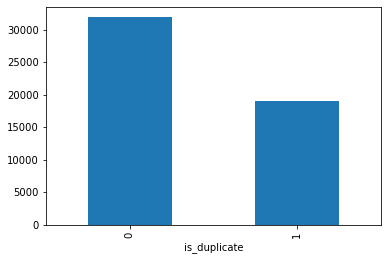

In [5]:
df.groupby("is_duplicate")['id'].count().plot.bar()
print('~> Question pairs are not Similar (is_duplicate = 0):\n   {}%'.format(100 - round(df['is_duplicate'].mean()*100, 2)))
print('\n~> Question pairs are Similar (is_duplicate = 1):\n   {}%'.format(round(df['is_duplicate'].mean()*100, 2)))


Based on the above result, we know it is an imbalanced dataset. The imbalanced classification dataset's accuracy is misleading. The overall accuracy would be high simply because one class has a higher percentage. 

### Resampling the dataset
Because we have over 10,000 data in the small classification, I will use under-sampling(removing samples from the majority class) to resample the dataset. This method does not add new data to the dataset.
The reason I choose under sampling not oversampling is:
1. I have 50863-row data, the quantity of data is sufficient.
2. The oversampling will create duplicated data. If an element is duplicated in the training data, it has its ‘weight’ doubled. That element becomes twice as important when the classifier is fitting the data, and the classifier becomes biased towards correctly classifying that particular scenario over others.

class 0: (31904, 6)
class 1: (18959, 6)
total class of 1 and 0: 0    18959
1    18959
Name: is_duplicate, dtype: int64


<AxesSubplot:title={'center':'count (target)'}>

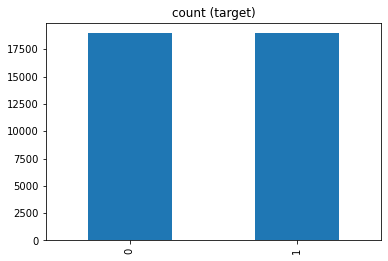

In [6]:
# class count
class_count_0, class_count_1 = df['is_duplicate'].value_counts()

# Separate class
class_0 = df[df['is_duplicate'] == 0]
class_1 = df[df['is_duplicate'] == 1]# print the shape of the class
print('class 0:', class_0.shape)
print('class 1:', class_1.shape)

class_0_under = class_0.sample(class_count_1)

undersampled_dataset_df = pd.concat([class_0_under, class_1], axis=0)

print("total class of 1 and 0:",undersampled_dataset_df['is_duplicate'].value_counts())# plot the count after under-sampeling
undersampled_dataset_df['is_duplicate'].value_counts().plot(kind='bar', title='count (target)')

In [7]:
df_b=undersampled_dataset_df
df_b.head()

,id,qid1,qid2,question1,question2,is_duplicate
41587,41587,75078,75079,In what ways is the Maury Show fake?,What is the best way to sell my TV show idea?,0
35459,35459,64798,64799,Has Modi's Pakistan Policy completely failed?,Is Pakistan afraid of Narendra Modi?,0
29464,29464,54512,39194,What is the difference between an electron and...,What are electrons made up of? Are all electro...,0
18247,18247,34580,34581,How do I start a youtube channel for cosmetics?,What's the best way to start a youtube channel?,0
3489,3489,6913,6914,What is living in Libya like for now?,What is it like to live in Libya?,0


## 3, Data Cleaning

I will clean the data using the following steps:
- Transform text to lower case
- Remove punctuation
- Word tokenization
- Remove stopwords
- Stemming
- Rejoining

In [9]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer 

#Transform text to lower case
df_b_l=df_b
df_b_l['question1']=df_b['question1'].astype(str).str.lower()
df_b_l['question2']=df_b['question2'].astype(str).str.lower()

# Remove punctuation
df_b_l["question2"] = df_b_l['question2'].str.replace('[^\w\s]','', regex=True)
df_b_l["question1"] = df_b_l['question1'].str.replace('[^\w\s]','', regex=True)

# Word tokenization
def tokenize(column):
    tokens = nltk.word_tokenize(column)
    return [w for w in tokens if w.isalpha()] 
df_b_l['question1'] = df_b_l.apply(lambda x: tokenize(x['question1']), axis=1)
df_b_l['question2'] = df_b_l.apply(lambda x: tokenize(x['question2']), axis=1)

# Remove stopwords
def remove_stopwords(text):
    words=[w for w in text if w not in stopwords.words('english')]
    return words

df_b_l['question1']=df_b_l['question1'].apply(lambda x: remove_stopwords(x))
df_b_l['question2']=df_b_l['question2'].apply(lambda x: remove_stopwords(x))

# Stemming
def apply_stemming(tokenized_column):
    stemmer = PorterStemmer() 
    return [stemmer.stem(word) for word in tokenized_column]
df_b_l['question1'] = df_b_l['question1'].apply(lambda x: apply_stemming(x))
df_b_l['question2'] = df_b_l['question2'].apply(lambda x: apply_stemming(x))

# Rejoining
def rejoin_words(tokenized_column):
    return ( " ".join(tokenized_column))

df_b_l['question1'] = df_b_l['question1'].apply(lambda x: rejoin_words(x))
df_b_l['question2'] = df_b_l['question2'].apply(lambda x: rejoin_words(x))

df_b_l.to_csv('dataclean.csv',index=False)
df_b_l.head()

,id,qid1,qid2,question1,question2,is_duplicate
41587,41587,75078,75079,way mauri show fake,best way sell tv show idea,0
35459,35459,64798,64799,modi pakistan polici complet fail,pakistan afraid narendra modi,0
29464,29464,54512,39194,differ electron beta particl,electron made electron made materi,0
18247,18247,34580,34581,start youtub channel cosmet,best way start youtub channel,0
3489,3489,6913,6914,live libya like,like live libya,0


## 4, Feature Engineering
I will use the following features:<br>
q1len = Length of question1<br>
q2len = Length of question2<br>
q1_n_words = Number of words in Question 1<br>
q2_n_words = Number of words in Question 2<br>
word_Common = (Number of common unique words in Question 1 and Question 2)<br>
word_Unique =(Total num of unique words in Question 1 and Question 2)<br>
jaccard index = (word_common)/(word_Unique)<br>
I believe similar questions will have similar length, similar number of words, and high Jaccard Index, so I create these features.

In [10]:
df_b_l_f = pd.read_csv("dataclean.csv")

#  I calculate q1len and q2len
df_b_l_f['q1len'] = df_b_l_f['question1'].str.len() 
df_b_l_f['q2len'] = df_b_l_f['question2'].str.len()

#  I calculate q1_n_words and q2_n_words
df_b_l_f['q1_n_words'] = df_b_l_f['question1'].apply(lambda row: len(str(row).split(" ")))
df_b_l_f['q2_n_words'] = df_b_l_f['question2'].apply(lambda row: len(str(row).split(" ")))

#  I calculate word_Common
def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), str(row['question1']).split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), str(row['question2']).split(" ")))    
        return 1.0 * len(w1 & w2)
df_b_l_f['word_Common'] = df_b_l_f.apply(normalized_word_Common, axis=1)

#  I calculate word_unique
def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), str(row['question1']).split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), str(row['question2']).split(" ")))    
        return 1.0 * len(set(w1 | w2))
df_b_l_f['word_unique'] = df_b_l_f.apply(normalized_word_Common, axis=1)

#  I calculate jaccard index
def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), str(row['question1']).split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), str(row['question2']).split(" ")))    
        return 1.0 * len(w1 & w2)/len(set(w1 | w2))
df_b_l_f['jaccard_index'] = df_b_l_f.apply(normalized_word_share, axis=1)

df_b_l_f.to_csv("clean_feature.csv", index=False)
df_b_l_f.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_unique,jaccard_index
0,41587,75078,75079,way mauri show fake,best way sell tv show idea,0,19.0,26.0,4,6,2.0,8.0,0.250000
1,35459,64798,64799,modi pakistan polici complet fail,pakistan afraid narendra modi,0,33.0,29.0,5,4,2.0,7.0,0.285714
2,29464,54512,39194,differ electron beta particl,electron made electron made materi,0,28.0,34.0,4,5,1.0,6.0,0.166667
3,18247,34580,34581,start youtub channel cosmet,best way start youtub channel,0,27.0,29.0,4,5,3.0,6.0,0.500000
4,3489,6913,6914,live libya like,like live libya,0,15.0,15.0,3,3,3.0,3.0,1.000000


I calculate the feature correlations

In [11]:
df_b_l_f.corr()

,id,qid1,qid2,is_duplicate,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_unique,jaccard_index
id,1.000000,0.854736,0.857866,0.000588,-0.001042,0.004600,-0.003251,0.004096,0.005182,-0.001225,0.000959
qid1,0.854736,1.000000,0.836841,-0.110332,0.012008,0.009126,0.008386,0.008597,-0.021280,0.018392,-0.010246
qid2,0.857866,0.836841,1.000000,-0.107486,0.011779,0.020611,0.008602,0.020082,-0.017973,0.024420,-0.010323
is_duplicate,0.000588,-0.110332,-0.107486,1.000000,-0.197200,-0.182261,-0.187540,-0.183527,0.248073,-0.322037,0.407500
q1len,-0.001042,0.012008,0.011779,-0.197200,1.000000,0.532703,0.965658,0.509486,0.344606,0.772397,-0.307836
q2len,0.004600,0.009126,0.020611,-0.182261,0.532703,1.000000,0.515476,0.970910,0.331064,0.803381,-0.297964
q1_n_words,-0.003251,0.008386,0.008602,-0.187540,0.965658,0.515476,1.000000,0.526389,0.359571,0.797807,-0.311340
q2_n_words,0.004096,0.008597,0.020082,-0.183527,0.509486,0.970910,0.526389,1.000000,0.333049,0.826549,-0.307664
word_Common,0.005182,-0.021280,-0.017973,0.248073,0.344606,0.331064,0.359571,0.333049,1.000000,0.071826,0.559936
word_unique,-0.001225,0.018392,0.024420,-0.322037,0.772397,0.803381,0.797807,0.826549,0.071826,1.000000,-0.602886


Based on the above data, I know jaccard index has a strong positive correlation to word_common, and a strong negative to word_unique. Work_unique has a strong correlation to q1len, q2len,qu_n_words and q2_n_words.

## 5, Modeling
When user input a question, the user will hope to get the reply if there were already similar questions in very short time. This will demand the model calculate fast. I will also calculate the feature importance, so I choose to use decision tree model.

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

df_b_l_f = pd.read_csv("clean_feature.csv")

df_b_l_f=df_b_l_f.dropna()

y=df_b_l_f['is_duplicate']
X=df_b_l_f.drop(['is_duplicate', 'question1','question2','qid1','qid2','id'], axis = 1)

# split the dataset to training dataset and test dataset
x_train,x_cv,y_train,y_cv=train_test_split(X,y,test_size=0.2,random_state=1)


In [34]:
from sklearn.tree import DecisionTreeClassifier
n_features = X.shape[1]
n_samples = X.shape[0]

grid = GridSearchCV(DecisionTreeClassifier(random_state=1), cv=3, n_jobs=-1, verbose=5,
                    param_grid ={'max_depth': [None,1,3,4,5,6,7,8,9,10,12,15,20,30,40]
                                         },
                    )

grid.fit(x_train, y_train)

print('Train Accuracy : %.3f'%grid.best_estimator_.score(x_train, y_train))
print('Test Accuracy : %.3f'%grid.best_estimator_.score(x_cv,y_cv))
print('Best Score Through Grid Search : %.3f'%grid.best_score_)
print('Best Parameters : ',grid.best_params_)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
Train Accuracy : 0.704
Test Accuracy : 0.697
Best Score Through Grid Search : 0.701
Best Parameters :  {'max_depth': 5}


I check the model overfitting

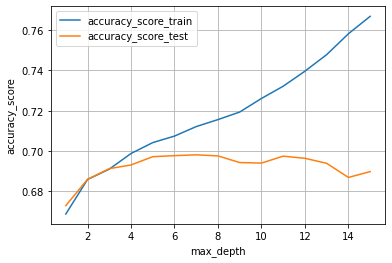

In [36]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
dt_height = []
training_errs = []
testing_errs = []


df = pd.DataFrame(columns=['max_depth', 'accuracy_score_train', 'accuracy_score_test'])
for itera in range(15):
    
    rf = DecisionTreeClassifier(max_depth = (itera+1))
    rf.fit(x_train,y_train)
    y_train_predicted = rf.predict(x_train)
    y_test_predicted = rf.predict(x_cv)
    accuracy_score_train =accuracy_score(y_train, y_train_predicted)
    accuracy_score_test = accuracy_score(y_cv, y_test_predicted)

    dt_height.append(itera+1)
    training_errs.append(accuracy_score_train)
    testing_errs.append(accuracy_score_test)
    

plt.plot(dt_height, training_errs, label="accuracy_score_train")
plt.plot(dt_height, testing_errs, label="accuracy_score_test")

plt.xlabel("max_depth")
plt.ylabel("accuracy_score")
plt.grid(which='major', axis='both')

plt.legend()
plt.show()

When the max_depth is over 11, the test data accuracy begin to decrease.

### Feature importance based on Decision Tree 

<AxesSubplot:>

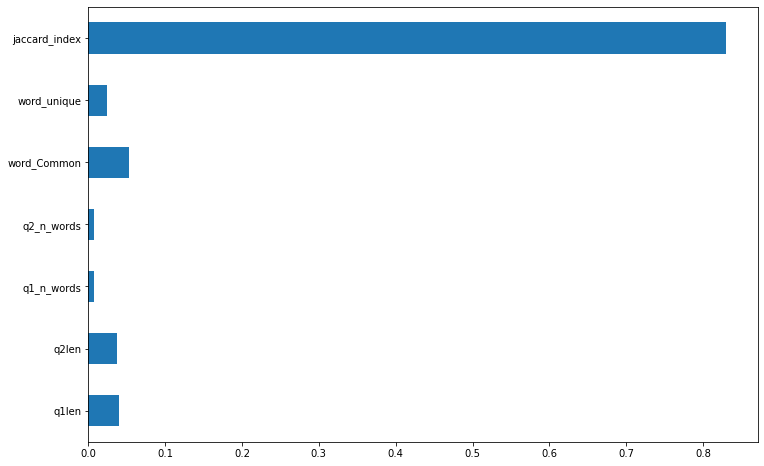

In [37]:
DecisionTree_model = DecisionTreeClassifier(random_state=1,max_depth=8)
DecisionTree_model.fit(x_train,y_train)
importances = pd.Series(DecisionTree_model.feature_importances_,index=X.columns)
importances.plot(kind='barh', figsize=(12,8))

Based on the above chart, we know jaccard index is the most important feature.

### Feature importance based on feature permutation

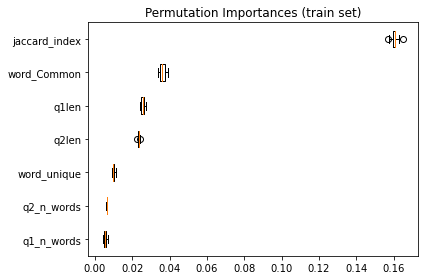

In [38]:
from sklearn.inspection import permutation_importance
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

model = DecisionTreeClassifier(random_state=1,max_depth=8)
model.fit(x_train,y_train)

result = permutation_importance(
    model, x_train, y_train, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(
    result.importances[sorted_idx].T, vert=False, labels=x_train.columns[sorted_idx]
)
ax.set_title("Permutation Importances (train set)")
fig.tight_layout()
plt.show()

Based on the above chart, we know jaccard index is the most important feature. The conclusion is same with decision tree feature importance.

### save the model to file

In [39]:
import pickle
# save the model to disk
filename = 'finalized_model.sav'
model=grid
pickle.dump(model, open(filename, 'wb'))

In [40]:
# load the model from disk
filename = 'finalized_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(x_cv, y_cv)
print(result)

0.6972016895459345


## 6, find the same question

Create a unique questions dataframe

In [41]:
import pandas as pd
df = pd.read_csv("train.csv", encoding='cp1252')
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
questions = pd.Series(df['question1'].tolist() + df['question2'].tolist())
unique_questions=questions.unique()
df_one = pd.DataFrame(unique_questions, columns = ['question'])
df_one.head()

,question
0,What is the step by step guide to invest in sh...
1,What is the story of Kohinoor (Koh-i-Noor) Dia...
2,How can I increase the speed of my internet co...
3,Why am I mentally very lonely? How can I solve...
4,"Which one dissolve in water quikly sugar, salt..."


I will define the same question based on a broad criteria. If after changing lower case, removing punctuation, tokenization, removing stop words and stems, two questions are same, I will define they are same questions.

In [33]:
import pandas as pd

#Transform text to lower case
df_one['question_new']=df_one['question'].str.lower()

#Remove punctuation
df_one['question_new'] = df_one['question_new'].str.replace('[^\w\s]','', regex=True)

# Word tokenization
import nltk
df_one=df_one.dropna()

def tokenize(column):
    tokens = nltk.word_tokenize(column)
    return [w for w in tokens if w.isalpha()] 
df_one['question_new'] = df_one.apply(lambda x: tokenize(x['question_new']), axis=1)

# Remove stopwords
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer 

def remove_stopwords(text):
    words=[w for w in text if w not in stopwords.words('english')]
    return words
df_one['question_new']=df_one['question_new'].apply(lambda x: remove_stopwords(x))

# Stemming
def apply_stemming(tokenized_column):
    stemmer = PorterStemmer() 
    return [stemmer.stem(word) for word in tokenized_column]
df_one['question_new'] = df_one.apply(lambda x: apply_stemming(x['question_new']), axis=1)

# Rejoining
def rejoin_words(tokenized_column):
    
    return ( " ".join(tokenized_column))
df_one['question_new'] = df_one.apply(lambda x: rejoin_words(x['question_new']), axis=1)

df_one.to_csv('onelistdata.csv',index=False)
df_one.head()

,question,question_new
0,What is the step by step guide to invest in sh...,step step guid invest share market india
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,stori kohinoor kohinoor diamond
2,How can I increase the speed of my internet co...,increas speed internet connect use vpn
3,Why am I mentally very lonely? How can I solve...,mental lone solv
4,"Which one dissolve in water quikly sugar, salt...",one dissolv water quikli sugar salt methan car...


### input a question and search for same question

In [43]:
# get the question dataset
import pandas as pd
df_one2 = pd.read_csv("onelistdata.csv", encoding='cp1252')
df_one2= df_one2.loc[:, ~df_one2.columns.str.contains('^Unnamed')]

# input words
new_question=input('input your question: ')

# Transform text to lower case
new_question2=new_question.lower()

# Remove punctuation
punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
no_punct = ""
for char in new_question2:
   if char not in punctuations:
       no_punct = no_punct + char
new_question2 = no_punct

# Word tokenization
import nltk
from nltk.tokenize import word_tokenize
def tokenize(column):
    tokens = nltk.word_tokenize(column)
    return [w for w in tokens if w.isalpha()] 
new_question2=tokenize(new_question2)

# Remove stopwords
from nltk.corpus import stopwords
en_stops = set(stopwords.words('english'))

filtered_sentence = []
for word in new_question2: 
    if word not in en_stops:
         filtered_sentence.append(word)
new_question2=filtered_sentence

# import these modules
from nltk.stem import PorterStemmer

ps = PorterStemmer()
 
# Stemming
filtered_sentence = []
for w in new_question2:
     filtered_sentence.append(ps.stem(w))
new_question2=filtered_sentence

# Rejoining
new_question2 = ' '.join(map(str, new_question2))

### search the dataset to find if there is same question

df_result=df_one2[df_one2['question_new']==new_question2]['question']
pd.options.display.max_colwidth = 90  # set a value as your need
print("Find the same question", df_result)

input your question: mental lone solv china
Find the same question Series([], Name: question, dtype: object)


## 7,  Use the Model to find similar question for user

In [45]:
df_one2 = pd.read_csv("onelistdata.csv", encoding='cp1252')
df_one2= df_one2.loc[:, ~df_one2.columns.str.contains('^Unnamed')]
df_one2['input_question']=new_question2

df_b_l_f=df_one2
#  I calculate q1len and q2len
df_b_l_f['q1len'] = df_b_l_f['question_new'].str.len() 
df_b_l_f['q2len'] = df_b_l_f['input_question'].str.len()

#  I calculate q1_n_words and q2_n_words
df_b_l_f['q1_n_words'] = df_b_l_f['question_new'].apply(lambda row: len(str(row).split(" ")))
df_b_l_f['q2_n_words'] = df_b_l_f['input_question'].apply(lambda row: len(str(row).split(" ")))

#  I calculate word_Common
def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), str(row['question_new']).split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), str(row['input_question']).split(" ")))    
        return 1.0 * len(w1 & w2)
df_b_l_f['word_Common'] = df_b_l_f.apply(normalized_word_Common, axis=1)

#  I calculate word_unique
def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), str(row['question_new']).split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), str(row['input_question']).split(" ")))    
        return 1.0 * len(set(w1 | w2))
df_b_l_f['word_unique'] = df_b_l_f.apply(normalized_word_Common, axis=1)

#  I calculate jaccard index
def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), str(row['question_new']).split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), str(row['input_question']).split(" ")))    
        return 1.0 * len(w1 & w2)/len(set(w1 | w2))
df_b_l_f['jaccard_index'] = df_b_l_f.apply(normalized_word_share, axis=1)

#df_b_l_f.head()

df_b_l_f=df_b_l_f.dropna()

X=df_b_l_f.drop(['question','question_new','input_question'], axis = 1)

# load the model from disk
import pickle
filename = 'finalized_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))
y_pre=loaded_model.predict(X)
df_pre = pd.DataFrame(y_pre, columns = ['pre'])
result = pd.concat([df_one2, df_pre], axis=1)

df_result=result[result['pre']==1]['question']
pd.options.display.max_colwidth = 90  # set a value as your need
print("Find the similar question: ", df_result.iloc[0])


Find the similar question:  Why am I mentally very lonely? How can I solve it?


## 8. Conclusion
1. Because I check the model calculate fast, I used decision tree to find a similar question.
2. Most important feature is jaccard index.